In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
key = 2
vocab = [char for char in ' -ABCDEFGHIJKLMNOPQRSTUVWXYZ']

In [5]:
def encrypt(text, key):
    indexes = [vocab.index(char) for char in text]
    encrypted_indexes = [(key + idx) % len(vocab) for idx in indexes]
    encrypted_chars = [vocab[idx] for idx in encrypted_indexes]
    encrypted = ''.join(encrypted_chars)
    return encrypted

In [7]:
text = "HELLO-WORLD"
encrypted_text = encrypt(text, key)
print(encrypted_text)

JGNNQBYQTNF


In [8]:
import matplotlib.pyplot as plt
import numpy as np

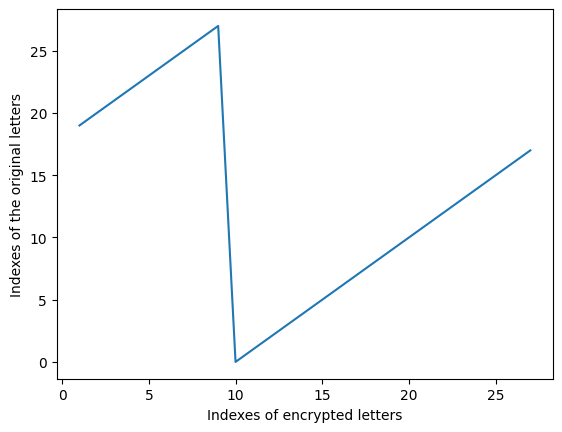

In [10]:
key = 10
plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - key) % len(vocab))
plt.ylabel('Indexes of the original letters')
plt.xlabel('Indexes of encrypted letters')
plt.show()

In [11]:
num_examples = 256
seq_len = 18

def encrypted_dataset(dataset_len, k):
    dataset = []
    for x in range(dataset_len):
        random_message = ''.join([random.choice(vocab) for _ in range(seq_len)])
        encrypt_random_message = encrypt(''.join(random_message), k)
        src = [vocab.index(char) for char in random_message]
        tgt = [vocab.index(char) for char in encrypt_random_message]
        dataset.append([torch.tensor(tgt), torch.tensor(src)])
    return dataset

In [14]:
df = encrypted_dataset(num_examples, k=2)
example = df[0]
print(example)

[tensor([ 1,  6, 11, 23, 20, 11, 13, 10, 19,  6, 21, 20, 19,  2,  0,  8, 24, 17]), tensor([27,  4,  9, 21, 18,  9, 11,  8, 17,  4, 19, 18, 17,  0, 26,  6, 22, 15])]


In [20]:
class Decipher(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, rnn_type='simple'):
        """
        :params: int vocab_size
        :params: int embedding_dim
        :params
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        if rnn_type == 'simple':
            self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.initial_hidden = torch.zeros(num_layers, 1, hidden_dim) 

    def forward(self, cipher):
        embd_x = self.embed(cipher).unsqueeze(1)
        out_rnn, hidden = self.rnn(embd_x, self.initial_hidden)
        return self.fc(out_rnn).transpose(1, 2) 

In [21]:
embedding_dim = 5
hidden_dim = 10
num_layers=2
vocab_size = len(vocab)
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
model = Decipher(vocab_size, embedding_dim, hidden_dim, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
num_epochs = 7

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 838 trainable parameters


Epoch: 0
Loss: 2.6532
Epoch: 1
Loss: 1.7233
Epoch: 2
Loss: 1.0017
Epoch: 3
Loss: 0.7679
Epoch: 4
Loss: 0.6469
Epoch: 5
Loss: 0.4722
Epoch: 6
Loss: 0.3123


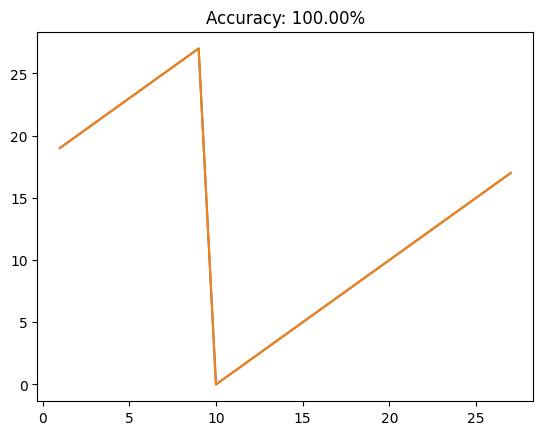

In [25]:
k = 10
for x in range(num_epochs):
    print('Epoch: {}'.format(x))
    for encrypted, original in encrypted_dataset(num_examples, k):
        scores = model(encrypted)
        original = original.unsqueeze(1)
        loss = criterion(scores, original)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Loss: {:6.4f}'.format(loss.item()))
    
with torch.no_grad():
    matches, total = 0, 0
    for encrypted, original in encrypted_dataset(num_examples, k):
        predictions = F.softmax(model(encrypted), dim=1)
        _, batch_out = predictions.max(dim=1)
        batch_out = batch_out.squeeze(1)
        matches += torch.eq(batch_out, original).sum().item()
        total += torch.numel(batch_out)
    accuracy = matches / total
    
    plt.title('Accuracy: {:4.2f}%'.format(accuracy * 100))
    plt.plot(range(1, len(vocab)), (np.arange(1, len(vocab)) - 10) % len(vocab))
    with torch.no_grad():
        plt.plot(range(1, len(vocab)), F.softmax(model(torch.tensor(range(1, len(vocab)))), 1).max(dim=1)[1])
    plt.show()

In [27]:
from scipy import linalg
list(map(linalg.norm, [model.rnn.weight_ih_l0.data, model.rnn.weight_hh_l0.data]))

[4.08745, 0.8552333]

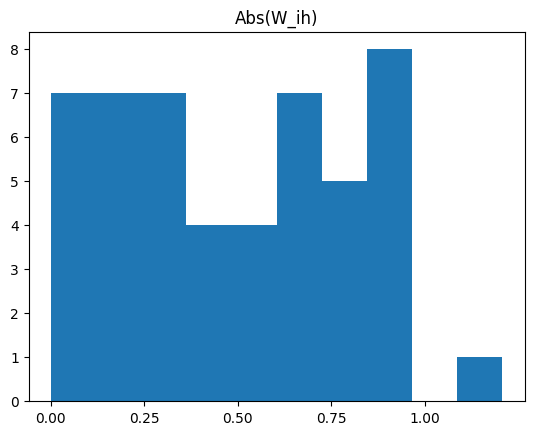

In [28]:
W_ih = model.rnn.weight_ih_l0.data.abs().numpy().ravel()
plt.title('Abs(W_ih)')
plt.hist(W_ih)
plt.xticks(np.linspace(0, 1, 5))
plt.show()

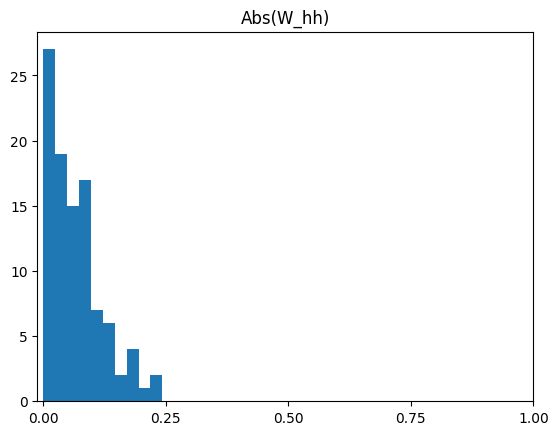

In [29]:
W_hh = model.rnn.weight_hh_l0.data.abs().numpy().ravel()
plt.title('Abs(W_hh)')
plt.hist(W_hh)
plt.xticks(np.linspace(0, 1, 5))
plt.show()

In [30]:
key = 10
print(encrypt('RNN IS NOT AI', key))

encrypt_message= '-XXISAIXYBIKS'
encrypt_tensor = torch.tensor([vocab.index(char) for char in encrypt_message])
with torch.no_grad():
    real_tensor = model(encrypt_tensor)
    real_indexes = real_tensor.max(dim=1)[1].numpy().ravel()
    print(''.join([vocab[real_index] for real_index in real_indexes]))

-XXISAIXYBIKS
RNN IS NOT AI
